##### 5conv+3fc加入BN

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000, 8192:]
vali = data[49000:, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
x_image = tf.reshape(x, [-1, 32, 32, 10])
keep_prob = tf.placeholder("float")
is_train = tf.placeholder("bool")

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)

h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)

h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2,is_training = is_train,decay = 0.9))

h_pool3 = max_pool_2x2(h_conv3_2)

# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([1024, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
step_num = 20000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5,is_train : True})
    if i%500 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0,is_train : False})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0,is_train : False})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0,is_train : False})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0,is_train : False})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (49000, 10257)
The shape of vali is  (1989, 10257)
step 0, train accuracy 0.0703125, vali accuracy 0.0618401, train loss 3822.25
step 500, train accuracy 0.402344, vali accuracy 0.383107, train loss 540.908
step 1000, train accuracy 0.511719, vali accuracy 0.467069, train loss 385.871
step 1500, train accuracy 0.476562, vali accuracy 0.487682, train loss 380.145
step 2000, train accuracy 0.527344, vali accuracy 0.494721, train loss 362.91
step 2500, train accuracy 0.519531, vali accuracy 0.542484, train loss 360.577
step 3000, train accuracy 0.605469, vali accuracy 0.535445, train loss 318.167
step 3500, train accuracy 0.621094, vali accuracy 0.598793, train loss 284.177
step 4000, train accuracy 0.554688, vali accuracy 0.552036, train loss 324.043
step 4500, train accuracy 0.585938, vali accuracy 0.589744, train loss 296.561
step 5000, train accuracy 0.675781, vali accuracy 0.63449, train loss 268.367
step 5500, train accuracy 0.695312, vali accuracy 0.662645, t

In [2]:
step_num = 10000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5,is_train : True})
    if i%500 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0,is_train : False})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0,is_train : False})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0,is_train : False})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0,is_train : False})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))

step 0, train accuracy 0.910156, vali accuracy 0.789341, train loss 81.7718
step 500, train accuracy 0.847656, vali accuracy 0.802916, train loss 111.359
step 1000, train accuracy 0.902344, vali accuracy 0.788839, train loss 97.4538
step 1500, train accuracy 0.902344, vali accuracy 0.804927, train loss 77.0319
step 2000, train accuracy 0.859375, vali accuracy 0.785822, train loss 109.004
step 2500, train accuracy 0.882812, vali accuracy 0.783308, train loss 88.08
step 3000, train accuracy 0.855469, vali accuracy 0.794872, train loss 105.364
step 3500, train accuracy 0.894531, vali accuracy 0.804927, train loss 94.1286
step 4000, train accuracy 0.910156, vali accuracy 0.792861, train loss 68.9558
step 4500, train accuracy 0.925781, vali accuracy 0.800402, train loss 65.5766
step 5000, train accuracy 0.914062, vali accuracy 0.802916, train loss 70.9296
step 5500, train accuracy 0.929688, vali accuracy 0.801911, train loss 59.9251
step 6000, train accuracy 0.921875, vali accuracy 0.806938

In [3]:
step_num = 10000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5,is_train : True})
    if i%500 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0,is_train : False})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0,is_train : False})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0,is_train : False})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0,is_train : False})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))

step 0, train accuracy 0.957031, vali accuracy 0.822021, train loss 44.1466
step 500, train accuracy 0.953125, vali accuracy 0.794369, train loss 41.7617
step 1000, train accuracy 0.964844, vali accuracy 0.816491, train loss 40.8134
step 1500, train accuracy 0.972656, vali accuracy 0.817496, train loss 32.5335
step 2000, train accuracy 0.902344, vali accuracy 0.791855, train loss 68.7448
step 2500, train accuracy 0.953125, vali accuracy 0.804927, train loss 39.0637
step 3000, train accuracy 0.863281, vali accuracy 0.735043, train loss 117.113
step 3500, train accuracy 0.953125, vali accuracy 0.804927, train loss 40.6331
step 4000, train accuracy 0.964844, vali accuracy 0.821016, train loss 31.3935
step 4500, train accuracy 0.945312, vali accuracy 0.82554, train loss 44.4477
step 5000, train accuracy 0.964844, vali accuracy 0.832579, train loss 27.0681
step 5500, train accuracy 0.972656, vali accuracy 0.822021, train loss 29.1108
step 6000, train accuracy 0.980469, vali accuracy 0.83056

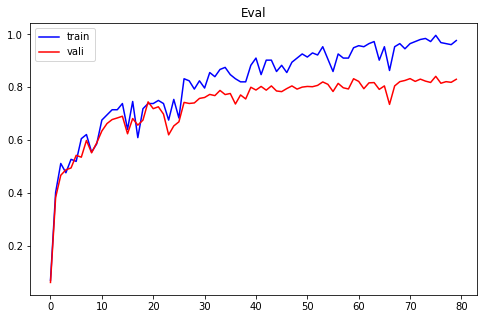

In [4]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

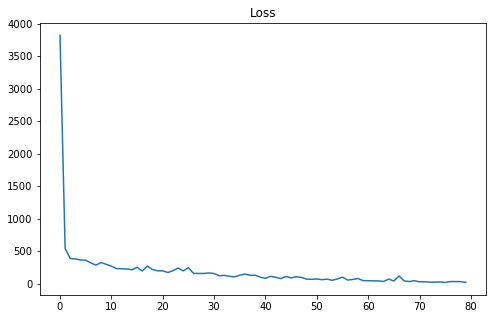

In [5]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [6]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0,is_train : False})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.74      0.76      0.75       115
          1       0.65      0.85      0.73       107
          2       0.68      0.79      0.73       130
          3       0.88      0.67      0.76       118
          4       0.65      0.57      0.61       141
          5       0.61      0.80      0.69       122
          6       0.94      0.93      0.93       121
          7       0.88      0.73      0.80       136
          8       0.78      0.76      0.77       117
          9       0.62      0.74      0.68        97
         10       0.95      0.93      0.94       108
         11       0.71      0.82      0.76       100
         12       0.96      0.80      0.87       112
         13       1.00      0.72      0.84       114
         14       0.96      0.93      0.94       107
         15       0.91      0.91      0.91       138
         16       1.00      1.00      1.00       106

avg / total       0.82      0.80      0.80  

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000, 8192:]
vali = data[49000:, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_pool3 = max_pool_2x2(h_conv3_2)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([1024, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
step_num = 10000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (49000, 10257)
The shape of vali is  (1989, 10257)
step 0, train accuracy 0.0390625, vali accuracy 0.0502765, train loss 3969.67
step 200, train accuracy 0.140625, vali accuracy 0.11463, train loss 3535.35
step 400, train accuracy 0.128906, vali accuracy 0.172951, train loss 3567.32
step 600, train accuracy 0.230469, vali accuracy 0.19457, train loss 3178.95
step 800, train accuracy 0.238281, vali accuracy 0.225742, train loss 3138.25
step 1000, train accuracy 0.289062, vali accuracy 0.269985, train loss 2937.66
step 1200, train accuracy 0.300781, vali accuracy 0.252388, train loss 2889.41
step 1400, train accuracy 0.261719, vali accuracy 0.26546, train loss 3050.47
step 1600, train accuracy 0.246094, vali accuracy 0.274007, train loss 3115.34
step 1800, train accuracy 0.242188, vali accuracy 0.261438, train loss 3121.53
step 2000, train accuracy 0.273438, vali accuracy 0.278532, train loss 3002.11
step 2200, train accuracy 0.308594, vali accuracy 0.281549, train

In [2]:
step_num = 10000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))

step 0, train accuracy 0.867188, vali accuracy 0.780794, train loss 113.351
step 200, train accuracy 0.851562, vali accuracy 0.781297, train loss 123.175
step 400, train accuracy 0.875, vali accuracy 0.783308, train loss 92.4138
step 600, train accuracy 0.835938, vali accuracy 0.786325, train loss 108.244
step 800, train accuracy 0.871094, vali accuracy 0.761689, train loss 99.4547
step 1000, train accuracy 0.871094, vali accuracy 0.788839, train loss 104.212
step 1200, train accuracy 0.898438, vali accuracy 0.801911, train loss 95.6336
step 1400, train accuracy 0.898438, vali accuracy 0.797386, train loss 83.7734
step 1600, train accuracy 0.898438, vali accuracy 0.799899, train loss 81.0157
step 1800, train accuracy 0.898438, vali accuracy 0.813977, train loss 94.1967
step 2000, train accuracy 0.925781, vali accuracy 0.798894, train loss 65.7338
step 2200, train accuracy 0.925781, vali accuracy 0.812469, train loss 61.1203
step 2400, train accuracy 0.910156, vali accuracy 0.809955, tr

In [4]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.82      0.77      0.79       115
          1       0.73      0.74      0.73       107
          2       0.79      0.78      0.78       130
          3       0.71      0.74      0.72       118
          4       0.61      0.63      0.62       141
          5       0.70      0.76      0.73       122
          6       0.94      0.95      0.95       121
          7       0.80      0.82      0.81       136
          8       0.86      0.85      0.86       117
          9       0.70      0.60      0.64        97
         10       0.89      0.93      0.91       108
         11       0.72      0.84      0.78       100
         12       0.90      0.81      0.85       112
         13       0.92      0.84      0.88       114
         14       0.91      0.95      0.93       107
         15       0.96      0.91      0.94       138
         16       1.00      1.00      1.00       106

avg / total       0.82      0.82      0.82  

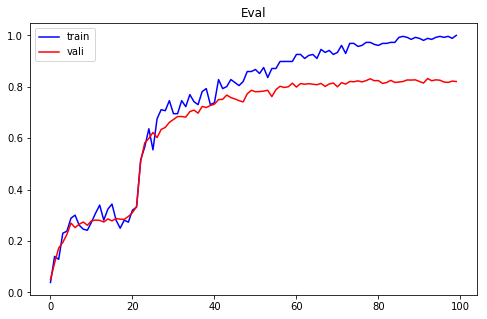

In [5]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

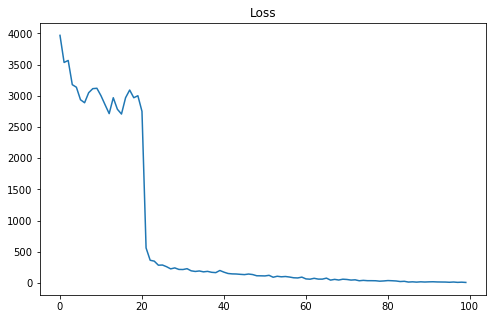

In [6]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000, 8192:]
vali = data[49000:, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_pool3 = max_pool_2x2(h_conv3_2)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([1024, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 512
step_num = 20000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (49000, 10257)
The shape of vali is  (1989, 10257)
step 0, train accuracy 0.0507812, vali accuracy 0.0593263, train loss 7823.85
step 200, train accuracy 0.175781, vali accuracy 0.173454, train loss 6806.25
step 400, train accuracy 0.220703, vali accuracy 0.229261, train loss 6410.81
step 600, train accuracy 0.257812, vali accuracy 0.226747, train loss 6085.6
step 800, train accuracy 0.320312, vali accuracy 0.278532, train loss 5578.01
step 1000, train accuracy 0.287109, vali accuracy 0.286073, train loss 5802.51
step 1200, train accuracy 0.322266, vali accuracy 0.295626, train loss 5535.8
step 1400, train accuracy 0.3125, vali accuracy 0.308698, train loss 5625.73
step 1600, train accuracy 0.333984, vali accuracy 0.295123, train loss 5413.42
step 1800, train accuracy 0.484375, vali accuracy 0.452489, train loss 875.202
step 2000, train accuracy 0.533203, vali accuracy 0.529412, train loss 691.498
step 2200, train accuracy 0.625, vali accuracy 0.580694, train los

KeyboardInterrupt: 

In [2]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.81      0.65      0.72       115
          1       0.76      0.61      0.67       107
          2       0.74      0.76      0.75       130
          3       0.73      0.76      0.75       118
          4       0.63      0.61      0.62       141
          5       0.69      0.80      0.74       122
          6       0.87      0.91      0.89       121
          7       0.76      0.87      0.81       136
          8       0.89      0.85      0.87       117
          9       0.71      0.66      0.68        97
         10       0.97      0.94      0.95       108
         11       0.79      0.89      0.84       100
         12       0.92      0.89      0.90       112
         13       0.88      0.90      0.89       114
         14       0.91      0.96      0.94       107
         15       0.98      0.93      0.96       138
         16       0.99      0.99      0.99       106

avg / total       0.82      0.82      0.82  

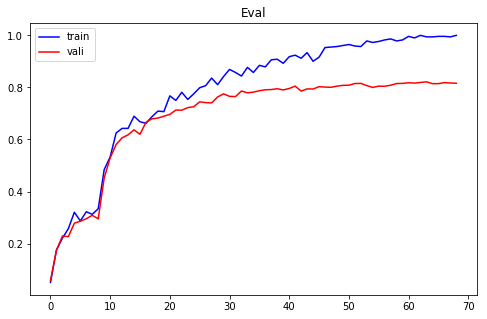

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

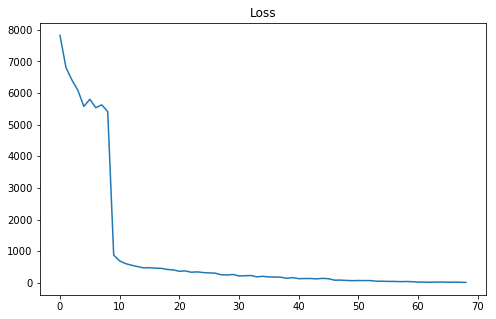

In [4]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000, 8192:]
vali = data[49000:, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
x_image = tf.reshape(x, [-1, 32, 32, 10])
keep_prob = tf.placeholder("float")
is_train = tf.placeholder("bool")

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)

h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)

h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2,is_training = is_train,decay = 0.9))

h_pool3 = max_pool_2x2(h_conv3_2)

# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([1024, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
step_num = 35000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5,is_train : True})
    if i%500 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0,is_train : False})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0,is_train : False})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0,is_train : False})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0,is_train : False})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (49000, 10257)
The shape of vali is  (1989, 10257)
step 0, train accuracy 0.0429688, vali accuracy 0.0603318, train loss 3840.58
step 500, train accuracy 0.34375, vali accuracy 0.370538, train loss 2063.5
step 1000, train accuracy 0.464844, vali accuracy 0.419306, train loss 428.26
step 1500, train accuracy 0.464844, vali accuracy 0.472599, train loss 399.534
step 2000, train accuracy 0.46875, vali accuracy 0.492207, train loss 396.799
step 2500, train accuracy 0.542969, vali accuracy 0.538462, train loss 363.994
step 3000, train accuracy 0.558594, vali accuracy 0.528909, train loss 334.924
step 3500, train accuracy 0.632812, vali accuracy 0.56913, train loss 313.381
step 4000, train accuracy 0.644531, vali accuracy 0.576169, train loss 282.483
step 4500, train accuracy 0.589844, vali accuracy 0.566616, train loss 309.742
step 5000, train accuracy 0.640625, vali accuracy 0.623932, train loss 265.234
step 5500, train accuracy 0.613281, vali accuracy 0.605329, trai

In [3]:
step_num = 15000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5,is_train : True})
    if i%500 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0,is_train : False})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0,is_train : False})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0,is_train : False})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0,is_train : False})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))

step 0, train accuracy 0.871094, vali accuracy 0.788839, train loss 105.085
step 500, train accuracy 0.789062, vali accuracy 0.739065, train loss 158.016
step 1000, train accuracy 0.898438, vali accuracy 0.788336, train loss 73.3091
step 1500, train accuracy 0.863281, vali accuracy 0.799899, train loss 87.19
step 2000, train accuracy 0.894531, vali accuracy 0.800905, train loss 75.0274
step 2500, train accuracy 0.90625, vali accuracy 0.798894, train loss 66.9381
step 3000, train accuracy 0.9375, vali accuracy 0.806435, train loss 54.2335
step 3500, train accuracy 0.929688, vali accuracy 0.807944, train loss 64.0895
step 4000, train accuracy 0.925781, vali accuracy 0.804927, train loss 63.2572
step 4500, train accuracy 0.945312, vali accuracy 0.803419, train loss 48.8339
step 5000, train accuracy 0.960938, vali accuracy 0.811966, train loss 45.7967
step 5500, train accuracy 0.964844, vali accuracy 0.817999, train loss 29.2945
step 6000, train accuracy 0.976562, vali accuracy 0.795375, t

In [4]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.73      0.77      0.75       115
          1       0.67      0.73      0.70       107
          2       0.83      0.74      0.78       130
          3       0.76      0.70      0.73       118
          4       0.66      0.65      0.65       141
          5       0.76      0.79      0.77       122
          6       0.95      0.94      0.95       121
          7       0.81      0.83      0.82       136
          8       0.85      0.79      0.82       117
          9       0.65      0.71      0.68        97
         10       0.94      0.88      0.91       108
         11       0.74      0.87      0.80       100
         12       0.88      0.89      0.88       112
         13       0.93      0.88      0.90       114
         14       0.95      0.96      0.96       107
         15       0.96      0.96      0.96       138
         16       1.00      1.00      1.00       106

avg / total       0.83      0.83      0.83  

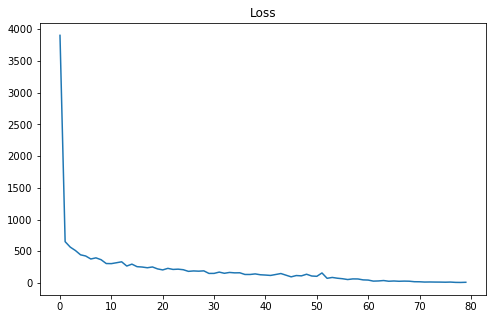

In [5]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

##### 1+2+3层卷积，3层全链接(256+256+17)，损失函数没加入正则化项

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000, 8192:]
vali = data[49000:, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

w_conv3_3 = weight_variable([3, 3, 256, 256])
b_conv3_3 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_conv3_3 = tf.nn.relu(conv2d(h_conv3_2, w_conv3_3) + b_conv3_3)
h_pool3 = max_pool_2x2(h_conv3_3)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 256])
b_fc1 = bias_variable([256])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([256, 256])
b_fc2 = bias_variable([256])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([256, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2)+tf.norm(w_conv3_3))
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
step_num = 30000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (49000, 10257)
The shape of vali is  (1989, 10257)
step 0, train accuracy 0.0429688, vali accuracy 0.0583208, train loss 3666.97
step 200, train accuracy 0.0429688, vali accuracy 0.0593263, train loss 3948.83
step 400, train accuracy 0.125, vali accuracy 0.100553, train loss 3610.45
step 600, train accuracy 0.105469, vali accuracy 0.116139, train loss 3691.04
step 800, train accuracy 0.175781, vali accuracy 0.167421, train loss 3389.21
step 1000, train accuracy 0.105469, vali accuracy 0.113122, train loss 3691.04
step 1200, train accuracy 0.144531, vali accuracy 0.162393, train loss 3529.86
step 1400, train accuracy 0.1875, vali accuracy 0.199095, train loss 3319.96
step 1600, train accuracy 0.214844, vali accuracy 0.204123, train loss 3231
step 1800, train accuracy 0.199219, vali accuracy 0.192559, train loss 3304.21
step 2000, train accuracy 0.164062, vali accuracy 0.196581, train loss 3449.27
step 2200, train accuracy 0.238281, vali accuracy 0.197084, train lo

step 20600, train accuracy 0.941406, vali accuracy 0.794369, train loss 43.9242
step 20800, train accuracy 0.957031, vali accuracy 0.801911, train loss 34.5664
step 21000, train accuracy 0.964844, vali accuracy 0.803922, train loss 38.6899
step 21200, train accuracy 0.957031, vali accuracy 0.80543, train loss 32.5921
step 21400, train accuracy 0.925781, vali accuracy 0.808446, train loss 52.0704
step 21600, train accuracy 0.972656, vali accuracy 0.803922, train loss 27.5725
step 21800, train accuracy 0.964844, vali accuracy 0.794369, train loss 29.8444
step 22000, train accuracy 0.980469, vali accuracy 0.806435, train loss 28.8412
step 22200, train accuracy 0.953125, vali accuracy 0.797888, train loss 33.7865
step 22400, train accuracy 0.960938, vali accuracy 0.816993, train loss 26.3663
step 22600, train accuracy 0.964844, vali accuracy 0.804424, train loss 30.0336
step 22800, train accuracy 0.964844, vali accuracy 0.803922, train loss 27.0679
step 23000, train accuracy 0.960938, vali

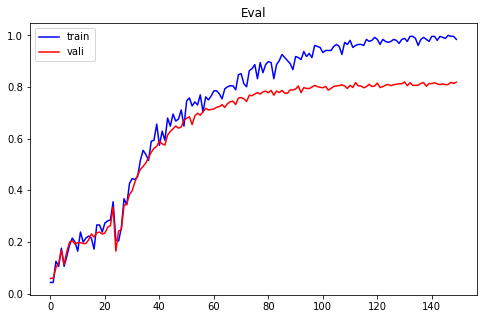

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

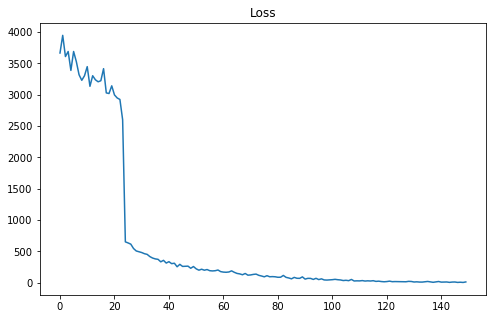

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [4]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.74      0.73      0.73       115
          1       0.77      0.65      0.71       107
          2       0.81      0.71      0.76       130
          3       0.72      0.73      0.72       118
          4       0.66      0.68      0.67       141
          5       0.67      0.74      0.70       122
          6       0.93      0.89      0.91       121
          7       0.80      0.78      0.79       136
          8       0.90      0.79      0.84       117
          9       0.58      0.72      0.65        97
         10       0.95      0.93      0.94       108
         11       0.80      0.89      0.84       100
         12       0.93      0.88      0.90       112
         13       0.88      0.90      0.89       114
         14       0.91      0.98      0.94       107
         15       0.96      0.96      0.96       138
         16       1.00      1.00      1.00       106

avg / total       0.82      0.82      0.82  

##### 加入L2正则项

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000, 8192:]
vali = data[49000:, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

w_conv3_3 = weight_variable([3, 3, 256, 256])
b_conv3_3 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_conv3_3 = tf.nn.relu(conv2d(h_conv3_2, w_conv3_3) + b_conv3_3)
h_pool3 = max_pool_2x2(h_conv3_3)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 256])
b_fc1 = bias_variable([256])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([256, 256])
b_fc2 = bias_variable([256])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([256, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2)+tf.norm(w_conv3_3))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
step_num = 30000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (49000, 10257)
The shape of vali is  (1989, 10257)
step 0, train accuracy 0.0507812, vali accuracy 0.0588235, train loss 3849.79
step 200, train accuracy 0.0703125, vali accuracy 0.0678733, train loss 3761.31
step 400, train accuracy 0.0625, vali accuracy 0.0854701, train loss 3796.51
step 600, train accuracy 0.113281, vali accuracy 0.1091, train loss 3662.24
step 800, train accuracy 0.148438, vali accuracy 0.145802, train loss 3486.65
step 1000, train accuracy 0.171875, vali accuracy 0.202112, train loss 3406.76
step 1200, train accuracy 0.199219, vali accuracy 0.165913, train loss 3287
step 1400, train accuracy 0.320312, vali accuracy 0.32177, train loss 1390.25
step 1600, train accuracy 0.332031, vali accuracy 0.333333, train loss 568.548
step 1800, train accuracy 0.394531, vali accuracy 0.379588, train loss 509.498
step 2000, train accuracy 0.40625, vali accuracy 0.411765, train loss 488.619
step 2200, train accuracy 0.449219, vali accuracy 0.419306, train lo

step 20600, train accuracy 0.984375, vali accuracy 0.811463, train loss 17.1952
step 20800, train accuracy 0.976562, vali accuracy 0.812469, train loss 23.6901
step 21000, train accuracy 0.996094, vali accuracy 0.827552, train loss 12.7931
step 21200, train accuracy 0.972656, vali accuracy 0.81448, train loss 26.0273
step 21400, train accuracy 0.988281, vali accuracy 0.828054, train loss 20.505
step 21600, train accuracy 0.980469, vali accuracy 0.822524, train loss 18.2792
step 21800, train accuracy 0.984375, vali accuracy 0.821518, train loss 17.1275
step 22000, train accuracy 0.992188, vali accuracy 0.82554, train loss 15.9414
step 22200, train accuracy 0.988281, vali accuracy 0.817999, train loss 14.8348
step 22400, train accuracy 0.980469, vali accuracy 0.804424, train loss 20.1764
step 22600, train accuracy 0.996094, vali accuracy 0.823027, train loss 11.5821
step 22800, train accuracy 0.96875, vali accuracy 0.825038, train loss 26.2989
step 23000, train accuracy 1, vali accuracy 

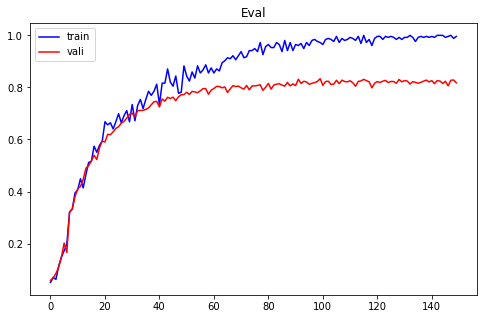

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

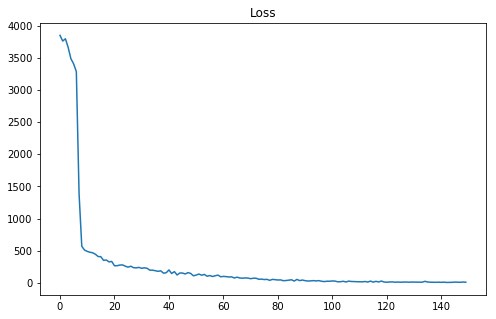

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [4]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.80      0.79      0.79       115
          1       0.73      0.76      0.74       107
          2       0.79      0.71      0.74       130
          3       0.83      0.69      0.75       118
          4       0.64      0.61      0.63       141
          5       0.68      0.80      0.73       122
          6       0.90      0.94      0.92       121
          7       0.82      0.87      0.84       136
          8       0.85      0.80      0.83       117
          9       0.64      0.72      0.68        97
         10       0.94      0.94      0.94       108
         11       0.78      0.87      0.82       100
         12       0.93      0.84      0.88       112
         13       0.90      0.90      0.90       114
         14       0.96      0.93      0.94       107
         15       0.95      0.96      0.95       138
         16       1.00      1.00      1.00       106

avg / total       0.83      0.83      0.83  

In [5]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s2 = f['sen2']

test = []
for i in range(0,test_s2.shape[0]):
    temp2 = test_s2[i].flatten()
    test.append(temp2)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

outname = '6_conv_3_fc_with_L2.csv'
out.to_csv(outname, index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


##### 加入BN层

In [1]:
# start tensorflow interactiveSession                              线上   0.781
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000, 8192:]
vali = data[49000:, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
is_train = tf.placeholder("bool")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(x_image, w_conv1_1) + b_conv1_1,is_training = is_train,decay = 0.9))
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2,is_training = is_train,decay = 0.9))
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

w_conv3_3 = weight_variable([3, 3, 256, 256])
b_conv3_3 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_conv3_3 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv3_2, w_conv3_3) + b_conv3_3,is_training = is_train,decay = 0.9))
h_pool3 = max_pool_2x2(h_conv3_3)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 256])
b_fc1 = bias_variable([256])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([256, 256])
b_fc2 = bias_variable([256])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([256, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2)+tf.norm(w_conv3_3))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 1024
step_num = 10000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5, is_train : True})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_loss = cross_entropy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g,vali loss %g" %(i, train_accuracy, vali_accuracy, temp_loss,vali_loss))



The shape of train is  (49000, 10257)
The shape of vali is  (1989, 10257)
step 0, train accuracy 0.0625, vali accuracy 0.0462544, train loss 2807.98,vali loss 21724.4
step 200, train accuracy 0.371094, vali accuracy 0.364505, train loss 519.368,vali loss 4267.04
step 400, train accuracy 0.476562, vali accuracy 0.440422, train loss 465.351,vali loss 3710.48
step 600, train accuracy 0.539062, vali accuracy 0.47461, train loss 400.986,vali loss 3355.51
step 800, train accuracy 0.578125, vali accuracy 0.526395, train loss 366.127,vali loss 2987.23
step 1000, train accuracy 0.632812, vali accuracy 0.570639, train loss 314.553,vali loss 2689.15
step 1200, train accuracy 0.648438, vali accuracy 0.59628, train loss 283.166,vali loss 2459.07
step 1400, train accuracy 0.667969, vali accuracy 0.620412, train loss 258.519,vali loss 2308.56
step 1600, train accuracy 0.6875, vali accuracy 0.637506, train loss 246.007,vali loss 2173.64
step 1800, train accuracy 0.6875, vali accuracy 0.652086, train l

In [4]:
step_num = 5000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5, is_train : True})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_loss = cross_entropy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g,vali loss %g" %(i, train_accuracy, vali_accuracy, temp_loss,vali_loss))



step 0, train accuracy 0.992188, vali accuracy 0.837104, train loss 12.8118,vali loss 1325.35
step 200, train accuracy 0.988281, vali accuracy 0.840121, train loss 11.2695,vali loss 1316.76
step 400, train accuracy 0.988281, vali accuracy 0.846154, train loss 12.6621,vali loss 1304.44
step 600, train accuracy 0.984375, vali accuracy 0.84364, train loss 16.2216,vali loss 1342.44
step 800, train accuracy 0.96875, vali accuracy 0.821518, train loss 21.4842,vali loss 1651.18
step 1000, train accuracy 0.992188, vali accuracy 0.829563, train loss 13.3818,vali loss 1466.96
step 1200, train accuracy 0.941406, vali accuracy 0.792861, train loss 44.6291,vali loss 1792.48
step 1400, train accuracy 0.996094, vali accuracy 0.827049, train loss 13.5202,vali loss 1391.71
step 1600, train accuracy 0.980469, vali accuracy 0.828557, train loss 15.5683,vali loss 1397.87
step 1800, train accuracy 0.992188, vali accuracy 0.830065, train loss 13.6996,vali loss 1368.72
step 2000, train accuracy 0.976562, val

##### 256

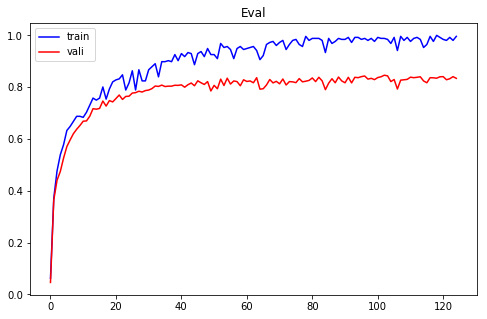

In [5]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

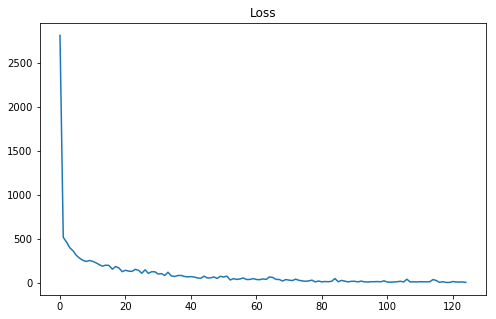

In [6]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [7]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0,is_train : False})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.76      0.74      0.75       115
          1       0.78      0.64      0.70       107
          2       0.89      0.57      0.69       130
          3       0.76      0.80      0.78       118
          4       0.69      0.59      0.64       141
          5       0.66      0.80      0.73       122
          6       0.96      0.90      0.93       121
          7       0.82      0.75      0.78       136
          8       0.87      0.79      0.83       117
          9       0.58      0.76      0.66        97
         10       0.93      0.95      0.94       108
         11       0.71      0.92      0.80       100
         12       0.88      0.90      0.89       112
         13       0.99      0.68      0.81       114
         14       0.73      1.00      0.85       107
         15       0.84      0.96      0.90       138
         16       1.00      0.99      1.00       106

avg / total       0.82      0.80      0.80  

##### 1024

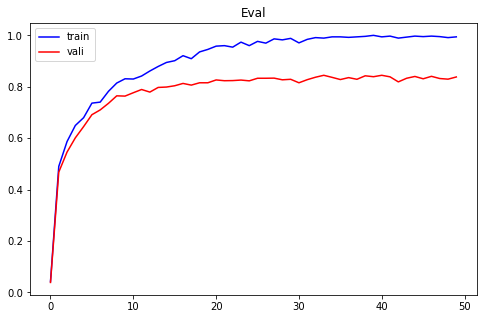

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

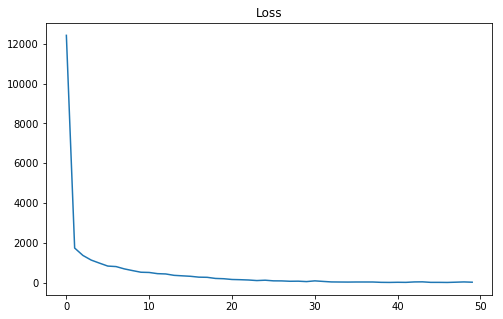

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [4]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0,is_train : False})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.74      0.86      0.80       115
          1       0.72      0.81      0.76       107
          2       0.74      0.81      0.77       130
          3       0.82      0.64      0.72       118
          4       0.72      0.59      0.65       141
          5       0.70      0.76      0.73       122
          6       0.93      0.94      0.93       121
          7       0.81      0.92      0.86       136
          8       0.90      0.82      0.86       117
          9       0.78      0.66      0.72        97
         10       0.95      0.93      0.94       108
         11       0.85      0.87      0.86       100
         12       0.91      0.85      0.88       112
         13       0.84      0.96      0.90       114
         14       0.94      0.95      0.94       107
         15       0.97      0.91      0.94       138
         16       1.00      1.00      1.00       106

avg / total       0.84      0.84      0.84  

In [6]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s2 = f['sen2']

test = []
for i in range(0,test_s2.shape[0]):
    temp2 = test_s2[i].flatten()
    test.append(temp2)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0,is_train : False})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0,is_train : False})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0,is_train : False})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0,is_train : False})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

outname = '6_conv_3_fc_with_L2_BN.csv'
out.to_csv(outname, index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


In [1]:
# start tensorflow interactiveSession                            线上   0.731  
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000, 8192:]
vali = data[49000:, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
is_train = tf.placeholder("bool")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(x_image, w_conv1_1) + b_conv1_1,is_training = is_train,decay = 0.9))
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2,is_training = is_train,decay = 0.9))
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

w_conv3_3 = weight_variable([3, 3, 256, 256])
b_conv3_3 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_conv3_3 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv3_2, w_conv3_3) + b_conv3_3,is_training = is_train,decay = 0.9))
h_pool3 = max_pool_2x2(h_conv3_3)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 256])
b_fc1 = bias_variable([256])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([256, 256])
b_fc2 = bias_variable([256])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([256, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2)+tf.norm(w_conv3_3))
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
step_num = 10000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5, is_train : True})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_loss = cross_entropy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g,vali loss %g" %(i, train_accuracy, vali_accuracy, temp_loss,vali_loss))



The shape of train is  (49000, 10257)
The shape of vali is  (1989, 10257)
step 0, train accuracy 0.046875, vali accuracy 0.0437406, train loss 3251.04,vali loss 24202.7
step 200, train accuracy 0.417969, vali accuracy 0.400704, train loss 485.108,vali loss 4001.21
step 400, train accuracy 0.496094, vali accuracy 0.462041, train loss 407.842,vali loss 3424.69
step 600, train accuracy 0.5625, vali accuracy 0.512318, train loss 353.577,vali loss 3132.25
step 800, train accuracy 0.578125, vali accuracy 0.550025, train loss 350.17,vali loss 2836.1
step 1000, train accuracy 0.574219, vali accuracy 0.575163, train loss 337.502,vali loss 2652.2
step 1200, train accuracy 0.601562, vali accuracy 0.583208, train loss 303.914,vali loss 2523.79
step 1400, train accuracy 0.636719, vali accuracy 0.612368, train loss 268.143,vali loss 2274.81
step 1600, train accuracy 0.71875, vali accuracy 0.647059, train loss 231.281,vali loss 2183.51
step 1800, train accuracy 0.636719, vali accuracy 0.667169, train

In [2]:
step_num = 20000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5, is_train : True})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_loss = cross_entropy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g,vali loss %g" %(i, train_accuracy, vali_accuracy, temp_loss,vali_loss))


step 0, train accuracy 0.941406, vali accuracy 0.809452, train loss 43.3094,vali loss 1194.72
step 200, train accuracy 0.929688, vali accuracy 0.831071, train loss 53.378,vali loss 1120.44
step 400, train accuracy 0.898438, vali accuracy 0.817999, train loss 68.4275,vali loss 1179.52
step 600, train accuracy 0.945312, vali accuracy 0.838612, train loss 40.9054,vali loss 1052.71
step 800, train accuracy 0.914062, vali accuracy 0.809452, train loss 59.6673,vali loss 1315.45
step 1000, train accuracy 0.972656, vali accuracy 0.827552, train loss 30.5444,vali loss 1132.62
step 1200, train accuracy 0.925781, vali accuracy 0.817999, train loss 50.8922,vali loss 1342.49
step 1400, train accuracy 0.964844, vali accuracy 0.817496, train loss 45.3033,vali loss 1177.27
step 1600, train accuracy 0.957031, vali accuracy 0.833082, train loss 34.5792,vali loss 1073.48
step 1800, train accuracy 0.96875, vali accuracy 0.830065, train loss 28.59,vali loss 1128.23
step 2000, train accuracy 0.949219, vali 

KeyboardInterrupt: 

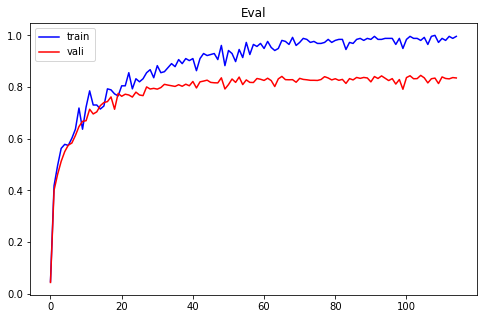

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

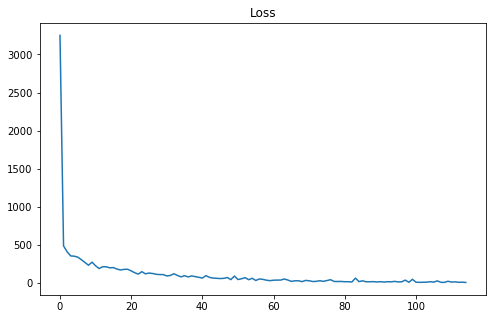

In [4]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [5]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0,is_train : False})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.79      0.77      0.78       115
          1       0.58      0.79      0.66       107
          2       0.82      0.72      0.77       130
          3       0.74      0.69      0.72       118
          4       0.60      0.63      0.62       141
          5       0.72      0.72      0.72       122
          6       0.96      0.91      0.94       121
          7       0.90      0.73      0.80       136
          8       0.90      0.80      0.85       117
          9       0.60      0.81      0.69        97
         10       0.97      0.88      0.92       108
         11       0.75      0.94      0.83       100
         12       0.91      0.86      0.88       112
         13       1.00      0.86      0.92       114
         14       0.97      0.98      0.98       107
         15       0.94      0.92      0.93       138
         16       1.00      1.00      1.00       106

avg / total       0.83      0.82      0.82  

In [6]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s2 = f['sen2']

test = []
for i in range(0,test_s2.shape[0]):
    temp2 = test_s2[i].flatten()
    test.append(temp2)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0,is_train : False})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0,is_train : False})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0,is_train : False})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0,is_train : False})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

outname = '6_conv_3_fc_with_BN.csv'
out.to_csv(outname, index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'
valiname = 'E:/Alibaba German AI Challenge/data_process/sample_of_training.npy'

data = np.load(filename)
vali = np.load(valiname)

train = data[:, 8192:]
vali = vali[:2000, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
is_train = tf.placeholder("bool")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(x_image, w_conv1_1) + b_conv1_1,is_training = is_train,decay = 0.9))
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2,is_training = is_train,decay = 0.9))
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

w_conv3_3 = weight_variable([3, 3, 256, 256])
b_conv3_3 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_conv3_3 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv3_2, w_conv3_3) + b_conv3_3,is_training = is_train,decay = 0.9))
h_pool3 = max_pool_2x2(h_conv3_3)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 256])
b_fc1 = bias_variable([256])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([256, 256])
b_fc2 = bias_variable([256])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([256, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2)+tf.norm(w_conv3_3))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []
Loss_vali = []

batch_size = 1024
step_num = 20000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5, is_train : True})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_loss = cross_entropy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        Loss_vali.append(vali_loss)
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g,vali loss %g" %(i, train_accuracy, vali_accuracy, temp_loss,vali_loss))



The shape of train is  (50989, 10257)
The shape of vali is  (2000, 10257)
step 0, train accuracy 0.0625, vali accuracy 0.0715, train loss 12580.6,vali loss 24967.7
step 200, train accuracy 0.491211, vali accuracy 0.4715, train loss 1723.12,vali loss 3408.13
step 400, train accuracy 0.603516, vali accuracy 0.5555, train loss 1331.03,vali loss 2826.57
step 600, train accuracy 0.645508, vali accuracy 0.5875, train loss 1104.16,vali loss 2543.19
step 800, train accuracy 0.713867, vali accuracy 0.605, train loss 940.807,vali loss 2445.89
step 1000, train accuracy 0.709961, vali accuracy 0.6205, train loss 914.888,vali loss 2353.51
step 1200, train accuracy 0.782227, vali accuracy 0.6385, train loss 751.356,vali loss 2205.75
step 1400, train accuracy 0.768555, vali accuracy 0.6655, train loss 715.277,vali loss 2042.31
step 1600, train accuracy 0.791992, vali accuracy 0.6655, train loss 630.096,vali loss 2108.86
step 1800, train accuracy 0.803711, vali accuracy 0.68, train loss 564.039,vali l

step 17400, train accuracy 0.99707, vali accuracy 0.748, train loss 19.2303,vali loss 3810.91
step 17600, train accuracy 0.999023, vali accuracy 0.7495, train loss 12.4976,vali loss 3844.57
step 17800, train accuracy 0.999023, vali accuracy 0.7375, train loss 7.44274,vali loss 4114.13
step 18000, train accuracy 0.998047, vali accuracy 0.7565, train loss 8.44909,vali loss 3501.39
step 18200, train accuracy 0.999023, vali accuracy 0.7585, train loss 12.7252,vali loss 3609.27
step 18400, train accuracy 0.99707, vali accuracy 0.7465, train loss 14.5655,vali loss 3735.68
step 18600, train accuracy 1, vali accuracy 0.749, train loss 10.2982,vali loss 3791
step 18800, train accuracy 0.998047, vali accuracy 0.764, train loss 13.3157,vali loss 3537.37
step 19000, train accuracy 0.996094, vali accuracy 0.7675, train loss 17.8663,vali loss 3375.72
step 19200, train accuracy 0.99707, vali accuracy 0.7625, train loss 19.9256,vali loss 3678.24
step 19400, train accuracy 0.99707, vali accuracy 0.776,

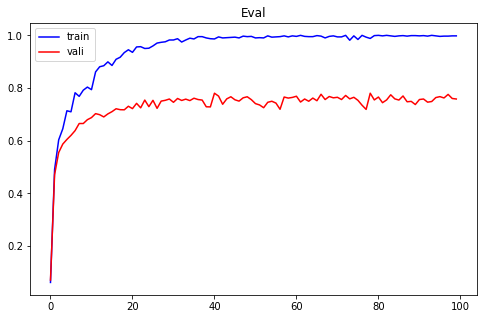

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

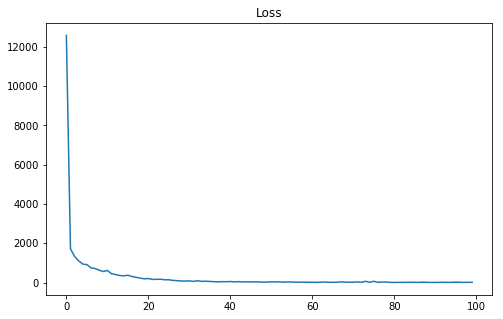

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

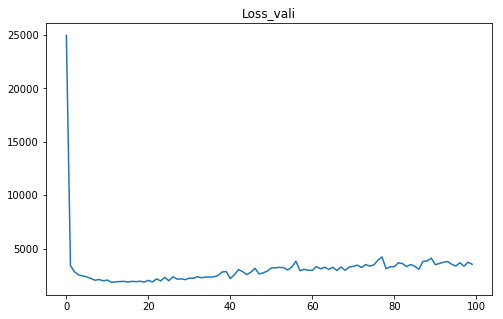

In [4]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss_vali)
plt.title('Loss_vali')
plt.show()

In [5]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s2 = f['sen2']

test = []
for i in range(0,test_s2.shape[0]):
    temp2 = test_s2[i].flatten()
    test.append(temp2)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0,is_train : False})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0,is_train : False})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0,is_train : False})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0,is_train : False})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

outname = '6_conv_3_fc_with_BN_all.csv'
out.to_csv(outname, index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


In [6]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0,is_train : False})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.58      1.00      0.74        32
          1       0.83      0.67      0.74       131
          2       0.94      0.42      0.58       179
          3       0.65      0.91      0.76        53
          4       0.50      0.73      0.60        88
          5       0.77      0.66      0.71       205
          6       0.58      0.88      0.70         8
          7       0.82      0.54      0.65       230
          8       0.61      0.72      0.66        75
          9       0.34      0.81      0.48        58
         10       0.98      0.87      0.92       255
         11       0.40      0.98      0.56        47
         12       0.66      0.98      0.79        56
         13       0.92      0.69      0.79       226
         14       0.37      1.00      0.54        11
         15       0.62      1.00      0.76        40
         16       0.99      0.98      0.98       306

avg / total       0.82      0.75      0.76  

##### GSG数据分类结果

In [1]:
# start tensorflow interactiveSession                              线上  0.508
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/s2/s2_data_shuffle_GSG.npy'

data = np.load(filename)

train = data[:50000,:]
vali = data[50000:,:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
is_train = tf.placeholder("bool")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(x_image, w_conv1_1) + b_conv1_1,is_training = is_train,decay = 0.9))
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2,is_training = is_train,decay = 0.9))
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

w_conv3_3 = weight_variable([3, 3, 256, 256])
b_conv3_3 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_conv3_3 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv3_2, w_conv3_3) + b_conv3_3,is_training = is_train,decay = 0.9))
h_pool3 = max_pool_2x2(h_conv3_3)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 256])
b_fc1 = bias_variable([256])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([256, 256])
b_fc2 = bias_variable([256])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([256, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2)+tf.norm(w_conv3_3))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
step_num = 30000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5, is_train : True})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_loss = cross_entropy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g,vali loss %g" %(i, train_accuracy, vali_accuracy, temp_loss,vali_loss))



The shape of train is  (50000, 10257)
The shape of vali is  (989, 10257)
step 0, train accuracy 0.0507812, vali accuracy 0.0444894, train loss 3737.92,vali loss 14695
step 200, train accuracy 0.429688, vali accuracy 0.408493, train loss 501.146,vali loss 1965.79
step 400, train accuracy 0.503906, vali accuracy 0.500506, train loss 395.678,vali loss 1623.87
step 600, train accuracy 0.558594, vali accuracy 0.557128, train loss 377.025,vali loss 1421.65
step 800, train accuracy 0.597656, vali accuracy 0.586451, train loss 334.484,vali loss 1347.61
step 1000, train accuracy 0.59375, vali accuracy 0.593529, train loss 331.773,vali loss 1208.6
step 1200, train accuracy 0.65625, vali accuracy 0.614762, train loss 270.31,vali loss 1165.03
step 1400, train accuracy 0.660156, vali accuracy 0.642063, train loss 269.496,vali loss 1083.08
step 1600, train accuracy 0.683594, vali accuracy 0.671385, train loss 242.5,vali loss 1016.44
step 1800, train accuracy 0.746094, vali accuracy 0.670374, train l

step 16800, train accuracy 0.992188, vali accuracy 0.826087, train loss 19.4378,vali loss 657.393
step 17000, train accuracy 0.976562, vali accuracy 0.835187, train loss 21.5761,vali loss 655.875
step 17200, train accuracy 0.964844, vali accuracy 0.831143, train loss 30.4283,vali loss 660.636
step 17400, train accuracy 0.929688, vali accuracy 0.788675, train loss 61.637,vali loss 906.249
step 17600, train accuracy 0.976562, vali accuracy 0.812942, train loss 21.5181,vali loss 712.753
step 17800, train accuracy 0.972656, vali accuracy 0.843276, train loss 22.2698,vali loss 682.113
step 18000, train accuracy 0.980469, vali accuracy 0.841254, train loss 21.3992,vali loss 610.862
step 18200, train accuracy 0.992188, vali accuracy 0.836198, train loss 19.6973,vali loss 682.71
step 18400, train accuracy 0.96875, vali accuracy 0.830131, train loss 20.7578,vali loss 658.7
step 18600, train accuracy 0.980469, vali accuracy 0.825076, train loss 26.1127,vali loss 699.449
step 18800, train accurac

In [4]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0,is_train : False})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.75      0.80      0.77        60
          1       0.76      0.69      0.72        54
          2       0.75      0.93      0.83        44
          3       0.70      0.72      0.71        61
          4       0.68      0.64      0.66        56
          5       0.92      0.77      0.84        73
          6       0.95      0.95      0.95        61
          7       0.83      0.84      0.84        70
          8       0.77      0.92      0.84        51
          9       0.84      0.71      0.77        58
         10       0.98      0.94      0.96        65
         11       0.79      0.95      0.86        59
         12       0.96      0.89      0.92        61
         13       0.98      0.88      0.93        59
         14       0.90      1.00      0.95        44
         15       0.95      0.94      0.94        62
         16       0.98      0.96      0.97        51

avg / total       0.86      0.85      0.85  

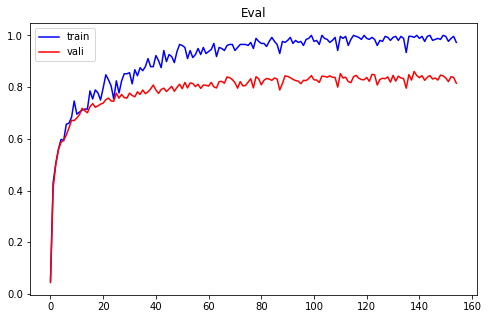

In [7]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

In [1]:
# start tensorflow interactiveSession                             
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/s2/s2_data_shuffle_GS.npy'

data = np.load(filename)

train = data[:50000,:]
vali = data[50000:,:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
is_train = tf.placeholder("bool")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(x_image, w_conv1_1) + b_conv1_1,is_training = is_train,decay = 0.9))
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2,is_training = is_train,decay = 0.9))
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

w_conv3_3 = weight_variable([3, 3, 256, 256])
b_conv3_3 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_conv3_3 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv3_2, w_conv3_3) + b_conv3_3,is_training = is_train,decay = 0.9))
h_pool3 = max_pool_2x2(h_conv3_3)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 256])
b_fc1 = bias_variable([256])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([256, 256])
b_fc2 = bias_variable([256])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([256, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2)+tf.norm(w_conv3_3))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
step_num = 30000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5, is_train : True})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_loss = cross_entropy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g,vali loss %g" %(i, train_accuracy, vali_accuracy, temp_loss,vali_loss))



The shape of train is  (50000, 10257)
The shape of vali is  (989, 10257)
step 0, train accuracy 0.0703125, vali accuracy 0.0626896, train loss 3334.64,vali loss 13228.9
step 200, train accuracy 0.441406, vali accuracy 0.445905, train loss 489.133,vali loss 1876.6
step 400, train accuracy 0.453125, vali accuracy 0.509606, train loss 436.673,vali loss 1594.38
step 600, train accuracy 0.554688, vali accuracy 0.54095, train loss 359.25,vali loss 1439.66
step 800, train accuracy 0.570312, vali accuracy 0.592518, train loss 334.055,vali loss 1266.86
step 1000, train accuracy 0.683594, vali accuracy 0.60364, train loss 259.917,vali loss 1207.71
step 1200, train accuracy 0.636719, vali accuracy 0.641052, train loss 282.033,vali loss 1124.64
step 1400, train accuracy 0.65625, vali accuracy 0.635996, train loss 298.299,vali loss 1076.9
step 1600, train accuracy 0.671875, vali accuracy 0.665318, train loss 248.511,vali loss 997.074
step 1800, train accuracy 0.742188, vali accuracy 0.688574, train

step 16800, train accuracy 0.988281, vali accuracy 0.840243, train loss 17.1155,vali loss 669.629
step 17000, train accuracy 0.992188, vali accuracy 0.826087, train loss 11.5662,vali loss 742.332
step 17200, train accuracy 0.996094, vali accuracy 0.851365, train loss 12.9989,vali loss 676.687
step 17400, train accuracy 0.996094, vali accuracy 0.846309, train loss 14.4827,vali loss 690.224
step 17600, train accuracy 0.996094, vali accuracy 0.842265, train loss 11.9892,vali loss 704.104
step 17800, train accuracy 0.988281, vali accuracy 0.842265, train loss 11.0937,vali loss 687.05
step 18000, train accuracy 0.988281, vali accuracy 0.82912, train loss 13.286,vali loss 733.788
step 18200, train accuracy 0.992188, vali accuracy 0.844287, train loss 14.2496,vali loss 696.405
step 18400, train accuracy 0.992188, vali accuracy 0.857432, train loss 11.2378,vali loss 718.254
step 18600, train accuracy 0.980469, vali accuracy 0.835187, train loss 20.1033,vali loss 759.9
step 18800, train accurac

In [2]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0,is_train : False})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.78      0.88      0.83        60
          1       0.68      0.72      0.70        54
          2       0.71      0.89      0.79        44
          3       0.84      0.61      0.70        61
          4       0.67      0.73      0.70        56
          5       0.83      0.73      0.77        73
          6       0.98      0.98      0.98        61
          7       0.82      0.84      0.83        70
          8       0.87      0.90      0.88        51
          9       0.73      0.60      0.66        58
         10       0.98      0.94      0.96        65
         11       0.88      0.86      0.87        59
         12       0.90      0.92      0.91        61
         13       0.92      0.93      0.92        59
         14       0.83      0.98      0.90        44
         15       0.92      0.94      0.93        62
         16       1.00      0.96      0.98        51

avg / total       0.85      0.84      0.84  

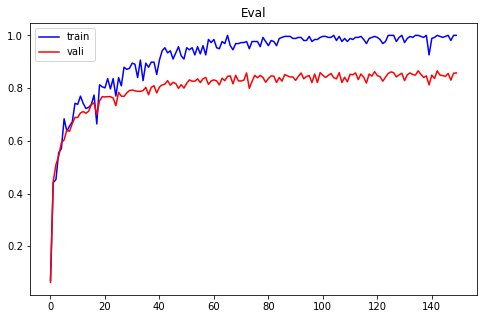

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

In [1]:
# start tensorflow interactiveSession                             
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/s2/s2_data_shuffle_GS.npy'

data = np.load(filename)

train = data[:50000,:]
vali = data[50000:,:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
is_train = tf.placeholder("bool")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(x_image, w_conv1_1) + b_conv1_1,is_training = is_train,decay = 0.9))
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2,is_training = is_train,decay = 0.9))
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

w_conv3_3 = weight_variable([3, 3, 256, 256])
b_conv3_3 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_conv3_3 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv3_2, w_conv3_3) + b_conv3_3,is_training = is_train,decay = 0.9))
h_pool3 = max_pool_2x2(h_conv3_3)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 256])
b_fc1 = bias_variable([256])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([256, 256])
b_fc2 = bias_variable([256])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([256, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2)+tf.norm(w_conv3_3))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
step_num = 30000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5, is_train : True})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_loss = cross_entropy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g,vali loss %g" %(i, train_accuracy, vali_accuracy, temp_loss,vali_loss))



The shape of train is  (50000, 10257)
The shape of vali is  (989, 10257)
step 0, train accuracy 0.00390625, vali accuracy 0.0101112, train loss 2276.8,vali loss 8475.39
step 200, train accuracy 0.328125, vali accuracy 0.404449, train loss 540.637,vali loss 1979.59
step 400, train accuracy 0.445312, vali accuracy 0.472194, train loss 426.926,vali loss 1653.8
step 600, train accuracy 0.550781, vali accuracy 0.535895, train loss 374.104,vali loss 1438.05
step 800, train accuracy 0.574219, vali accuracy 0.577351, train loss 348.752,vali loss 1362.19
step 1000, train accuracy 0.648438, vali accuracy 0.610718, train loss 307.134,vali loss 1219.39
step 1200, train accuracy 0.65625, vali accuracy 0.62184, train loss 279.906,vali loss 1170.07
step 1400, train accuracy 0.699219, vali accuracy 0.642063, train loss 254.638,vali loss 1055.6
step 1600, train accuracy 0.679688, vali accuracy 0.662285, train loss 249.675,vali loss 1032.23
step 1800, train accuracy 0.707031, vali accuracy 0.662285, tra

step 16800, train accuracy 0.957031, vali accuracy 0.803842, train loss 43.4453,vali loss 754.152
step 17000, train accuracy 0.992188, vali accuracy 0.833165, train loss 13.2007,vali loss 625.943
step 17200, train accuracy 0.960938, vali accuracy 0.826087, train loss 33.4911,vali loss 755.775
step 17400, train accuracy 0.988281, vali accuracy 0.833165, train loss 14.8264,vali loss 705.027
step 17600, train accuracy 0.957031, vali accuracy 0.819009, train loss 27.3013,vali loss 790.779
step 17800, train accuracy 0.980469, vali accuracy 0.842265, train loss 18.3135,vali loss 646.078
step 18000, train accuracy 0.964844, vali accuracy 0.813953, train loss 33.957,vali loss 704.752
step 18200, train accuracy 0.96875, vali accuracy 0.825076, train loss 28.1768,vali loss 720.105
step 18400, train accuracy 0.980469, vali accuracy 0.808898, train loss 20.8508,vali loss 759.323
step 18600, train accuracy 0.972656, vali accuracy 0.822042, train loss 23.8471,vali loss 743.904
step 18800, train accu

In [2]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0,is_train : False})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.84      0.87      0.85        60
          1       0.70      0.70      0.70        54
          2       0.87      0.75      0.80        44
          3       0.75      0.74      0.74        61
          4       0.72      0.59      0.65        56
          5       0.86      0.81      0.83        73
          6       1.00      0.90      0.95        61
          7       0.72      0.93      0.81        70
          8       0.82      0.90      0.86        51
          9       0.72      0.74      0.73        58
         10       0.98      0.92      0.95        65
         11       0.89      0.85      0.87        59
         12       0.89      0.93      0.91        61
         13       0.89      0.92      0.90        59
         14       0.98      0.98      0.98        44
         15       0.94      0.95      0.94        62
         16       0.98      0.96      0.97        51

avg / total       0.85      0.85      0.85  

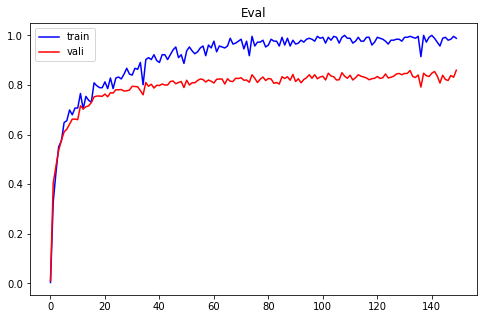

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

In [4]:
filename = 'test_s2_gs.npy'
test = np.load(filename)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0,is_train : False})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0,is_train : False})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0,is_train : False})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0,is_train : False})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

outname = '6_conv_3_fc_with_BN_gs.csv'
out.to_csv(outname, index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/s2/s2_data_shuffle.npy'
valiname = 'E:/Alibaba German AI Challenge/data_process/sample_of_training.npy'

data = np.load(filename)
vali = np.load(valiname)

train = data
vali = vali[:2000, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
is_train = tf.placeholder("bool")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(x_image, w_conv1_1) + b_conv1_1,is_training = is_train,decay = 0.9))
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2,is_training = is_train,decay = 0.9))
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

w_conv3_3 = weight_variable([3, 3, 256, 256])
b_conv3_3 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_conv3_3 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv3_2, w_conv3_3) + b_conv3_3,is_training = is_train,decay = 0.9))
h_pool3 = max_pool_2x2(h_conv3_3)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 512])
b_fc1 = bias_variable([512])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([512, 512])
b_fc2 = bias_variable([512])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([512, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2)+tf.norm(w_conv3_3))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []
Loss_vali = []

batch_size = 1024
step_num = 20000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5, is_train : True})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_loss = cross_entropy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        Loss_vali.append(vali_loss)
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g,vali loss %g" %(i, train_accuracy, vali_accuracy, temp_loss,vali_loss))



The shape of train is  (50989, 10257)
The shape of vali is  (2000, 10257)
step 0, train accuracy 0.0576172, vali accuracy 0.129, train loss 15351.3,vali loss 27255.3
step 200, train accuracy 0.455078, vali accuracy 0.4565, train loss 1898.92,vali loss 3621.61
step 400, train accuracy 0.548828, vali accuracy 0.5125, train loss 1487.99,vali loss 3078.27
step 600, train accuracy 0.609375, vali accuracy 0.5625, train loss 1246.82,vali loss 2743.16
step 800, train accuracy 0.657227, vali accuracy 0.5855, train loss 1109.16,vali loss 2567.29
step 1000, train accuracy 0.743164, vali accuracy 0.611, train loss 848.472,vali loss 2336.11
step 1200, train accuracy 0.716797, vali accuracy 0.622, train loss 850.402,vali loss 2318.77
step 1400, train accuracy 0.731445, vali accuracy 0.636, train loss 812.271,vali loss 2182.07
step 1600, train accuracy 0.792969, vali accuracy 0.6575, train loss 679.362,vali loss 2078.46
step 1800, train accuracy 0.793945, vali accuracy 0.668, train loss 647.728,vali 

step 17400, train accuracy 0.995117, vali accuracy 0.7645, train loss 25.4198,vali loss 3409.06
step 17600, train accuracy 0.998047, vali accuracy 0.766, train loss 10.7848,vali loss 3189.98
step 17800, train accuracy 0.998047, vali accuracy 0.783, train loss 15.6915,vali loss 2937.85


KeyboardInterrupt: 

In [2]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0,is_train : False})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.73      1.00      0.84        32
          1       0.74      0.70      0.72       131
          2       0.78      0.60      0.68       179
          3       0.81      0.89      0.85        53
          4       0.64      0.77      0.70        88
          5       0.72      0.78      0.74       205
          6       0.50      1.00      0.67         8
          7       0.95      0.57      0.72       230
          8       0.64      0.72      0.68        75
          9       0.39      0.81      0.53        58
         10       0.98      0.87      0.92       255
         11       0.40      0.98      0.56        47
         12       0.65      0.98      0.78        56
         13       0.98      0.59      0.74       226
         14       0.48      1.00      0.65        11
         15       0.70      0.97      0.81        40
         16       0.99      0.98      0.99       306

avg / total       0.83      0.78      0.78  

In [4]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s2 = f['sen2']

test = []
for i in range(0,test_s2.shape[0]):
    temp2 = test_s2[i].flatten()
    test.append(temp2)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0,is_train : False})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0,is_train : False})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0,is_train : False})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0,is_train : False})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

outname = '6_conv_3_fc_BN_new.csv'
out.to_csv(outname, index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/s2/s2_data_shuffle_gs_345789.npy'

data = np.load(filename)

train = data[:50000,:]
vali = data[50000:,:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
is_train = tf.placeholder("bool")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(x_image, w_conv1_1) + b_conv1_1,is_training = is_train,decay = 0.9))
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2,is_training = is_train,decay = 0.9))
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

w_conv3_3 = weight_variable([3, 3, 256, 256])
b_conv3_3 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_conv3_3 = tf.nn.relu(tf.contrib.layers.batch_norm(conv2d(h_conv3_2, w_conv3_3) + b_conv3_3,is_training = is_train,decay = 0.9))
h_pool3 = max_pool_2x2(h_conv3_3)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 512])
b_fc1 = bias_variable([512])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([512, 512])
b_fc2 = bias_variable([512])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([512, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2)+tf.norm(w_conv3_3))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []
Loss_vali = []

batch_size = 1024
step_num = 20000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5, is_train : True})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0, is_train : False})
        vali_loss = cross_entropy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0, is_train : False})
        Loss_vali.append(vali_loss)
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g,vali loss %g" %(i, train_accuracy, vali_accuracy, temp_loss,vali_loss))



The shape of train is  (50000, 10257)
The shape of vali is  (989, 10257)
step 0, train accuracy 0.0507812, vali accuracy 0.0637007, train loss 14611.3,vali loss 14032.4
step 200, train accuracy 0.470703, vali accuracy 0.476239, train loss 1764.36,vali loss 1710.7
step 400, train accuracy 0.5625, vali accuracy 0.554095, train loss 1420.54,vali loss 1395.33
step 600, train accuracy 0.642578, vali accuracy 0.618807, train loss 1140.29,vali loss 1205.3
step 800, train accuracy 0.681641, vali accuracy 0.654196, train loss 1000.54,vali loss 1043.61
step 1000, train accuracy 0.708984, vali accuracy 0.680485, train loss 925.724,vali loss 980.69
step 1200, train accuracy 0.761719, vali accuracy 0.709808, train loss 772.507,vali loss 876.782
step 1400, train accuracy 0.786133, vali accuracy 0.724975, train loss 717.12,vali loss 808.053
step 1600, train accuracy 0.78125, vali accuracy 0.742164, train loss 652.386,vali loss 785.398
step 1800, train accuracy 0.80957, vali accuracy 0.743175, train l

step 16800, train accuracy 0.993164, vali accuracy 0.844287, train loss 31.9919,vali loss 1030.32
step 17000, train accuracy 0.99707, vali accuracy 0.845298, train loss 18.5102,vali loss 1022.31
step 17200, train accuracy 0.999023, vali accuracy 0.852376, train loss 11.0728,vali loss 937.797
step 17400, train accuracy 0.999023, vali accuracy 0.851365, train loss 8.4341,vali loss 974.999
step 17600, train accuracy 1, vali accuracy 0.834176, train loss 9.00094,vali loss 979.34
step 17800, train accuracy 0.999023, vali accuracy 0.85541, train loss 11.0734,vali loss 1006.12
step 18000, train accuracy 0.996094, vali accuracy 0.839232, train loss 16.0714,vali loss 988.69
step 18200, train accuracy 0.996094, vali accuracy 0.863499, train loss 18.2765,vali loss 922.14
step 18400, train accuracy 0.996094, vali accuracy 0.848332, train loss 33.8359,vali loss 1020.53
step 18600, train accuracy 0.99707, vali accuracy 0.845298, train loss 14.9939,vali loss 978.504
step 18800, train accuracy 0.99902

In [2]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0,is_train : False})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.69      0.82      0.75        60
          1       0.79      0.63      0.70        54
          2       0.94      0.77      0.85        44
          3       0.60      0.77      0.68        61
          4       0.79      0.55      0.65        56
          5       0.83      0.75      0.79        73
          6       0.91      0.97      0.94        61
          7       0.84      0.80      0.82        70
          8       0.79      0.88      0.83        51
          9       0.79      0.78      0.78        58
         10       0.95      0.94      0.95        65
         11       0.83      0.88      0.85        59
         12       0.93      0.92      0.93        61
         13       0.90      0.93      0.92        59
         14       0.88      1.00      0.94        44
         15       0.92      0.92      0.92        62
         16       0.98      0.96      0.97        51

avg / total       0.84      0.84      0.84  

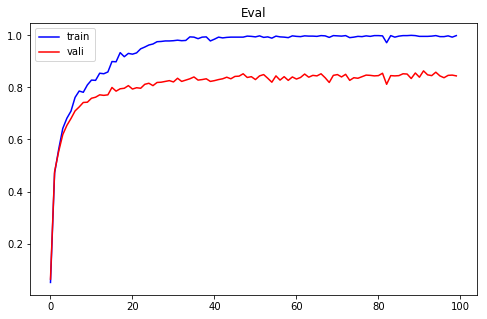

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

In [6]:
filename = 'E:/Alibaba German AI Challenge/data_process/s2/s2_test_gs_345789.npy'
test = np.load(filename)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0,is_train : False})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0,is_train : False})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0,is_train : False})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0,is_train : False})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

outname = 'BN_gs_345789.csv'
out.to_csv(outname, index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
